In [1]:
#Load Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Load Standard processing imports
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
#Load modeling and evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.inspection import permutation_importance
import joblib
#Set random state for reproducibility
SEED = 321 
np.random.seed(SEED)
#set pandas to display more columns
pd.set_option('display.max_columns',50)
#set pandas to eliminate scientific notation
#pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [19]:
filename = r'Data\sales_predictions.csv'

df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [20]:
#Quick Function for EDA analysis (proper EDA should still be conducted)

def summarize_df(df_):
    df = df_.copy()
    report = pd.DataFrame({
        'dtype':df.dtypes,
        '# null': df.isna().sum(),
        'null %': df.isna().sum()/len(df)*100,
        'nunique': df.nunique(),
        'min':df.min(),
        'max':df.max()        
    })
    report.index.name='Column'
    return report.reset_index()
summarize_df(df)

C:\Users\staichn\AppData\Local\Temp\ipykernel_31368\1971790721.py:10: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'min':df.min(),
C:\Users\staichn\AppData\Local\Temp\ipykernel_31368\1971790721.py:11: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'max':df.max()


,Column,dtype,# null,null %,nunique,min,max
0,Item_Fat_Content,object,0,0.000000,5,LF,reg
1,Item_Identifier,object,0,0.000000,1559,DRA12,NCZ54
2,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
3,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648
4,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
5,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
6,Item_Weight,float64,1463,17.165317,415,4.555,21.35
7,Outlet_Establishment_Year,int64,0,0.000000,9,1985,2009
8,Outlet_Identifier,object,0,0.000000,10,OUT010,OUT049
9,Outlet_Location_Type,object,0,0.000000,3,Tier 1,Tier 3


In [21]:
## convert Item_Outlet_Sales to a % out of 100
df['Item_Outlet_Sales(%)'] = (df['Item_Outlet_Sales']/13086) *100
df['Item_Outlet_Sales(%)'].head()

0    28.543008
1     3.388528
2    16.026823
3     5.596668
4     7.601293
Name: Item_Outlet_Sales(%), dtype: float64

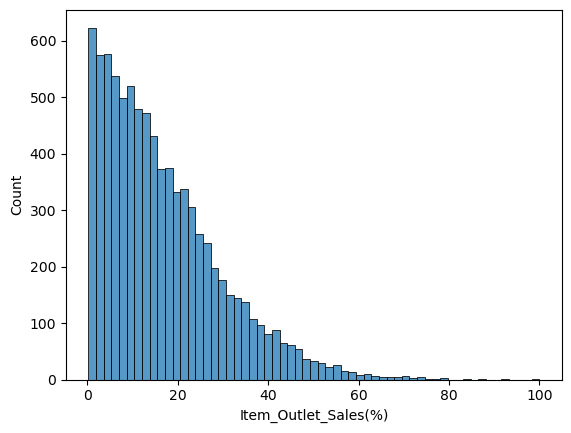

In [23]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='Item_Outlet_Sales(%)')

In [28]:
## defining bin edges
bins = [0, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,101]
bin_labels = ['0-5%','5-10%','0-5%','B','0-5%']
sales = pd.cut(df['Item_Outlet_Sales(%)'], bins=bins)
sales.value_counts().sort_index()

(0, 5]       1679
(5, 10]      1529
(10, 15]     1387
(15, 20]     1097
(20, 25]      918
(25, 30]      628
(30, 35]      442
(35, 40]      298
(40, 45]      224
(45, 50]      140
(50, 55]       83
(55, 60]       42
(60, 65]       24
(65, 70]       12
(70, 75]       12
(75, 80]        4
(80, 85]        1
(85, 90]        1
(90, 95]        1
(95, 101]       1
Name: Item_Outlet_Sales(%), dtype: int64

In [ ]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

# Load in Lin Reg Model

In [3]:
#Import joblib and the linear regression model
import joblib
loaded = joblib.load('lin_reg_proj1a.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression'])

In [4]:
#Reload and unpack the models and datasets
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['LinearRegression']

In [5]:
#This function is for the evaluation of regression models (excludes linear regression)
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [6]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [7]:
# This plots the logreg coeffs as odds...
def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), legend_loc='best',
                      threshold=None, color_lt='darkred', color_gt='forestgreen',
                      color_else='gray', label_thresh='Equally Likely',
                      label_gt='More Likely', label_lt='Less Likely',
                   plot_kws = {}):
    """Plots series of coefficients
        Args:
        ceoffs (pands Series): importance values to plot
        top_n (int): The # of features to display (Default=None).
                         If None, display all.
                        otherwise display top_n most important
                        
        figsize (tuple): figsize tuple for .plot
        color_dict (dict): dict with index values as keys with color to use as vals
                            Uses series.index.map(color_dict).
        plot_kws (dict): additional keyword args accepted by panda's .plot
        
         
         Returns:
        Axis: matplotlib axis
    """
        
    # sorting with asc=false for correct order of bars
    if top_n is None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        ## plotting top N importances
    if threshold is not None:
        color_dict = get_colors_gt_lt(plot_vals, threshold=threshold,
                                      color_gt=color_gt,color_lt=color_lt,
                                      color_else=color_else)
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws.update({'color':colors})
    
    
    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    
    if threshold is not None:
        ln1 = ax.axvline(threshold,ls=':',color='black')
        from matplotlib.patches import Patch
        box_lt = Patch(color=color_lt)
        box_gt = Patch(color=color_gt)
        handles = [ln1,box_gt,box_lt]
        labels = [label_thresh,label_gt,label_lt]
        ax.legend(handles,labels, loc=legend_loc)
    ## return ax in case want to continue to update/modify figure
    return ax


In [8]:
#This function creates a color dictionary to apply to the generated charts

def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

Training Data:	R^2= 0.56	RMSE= 1114.87
Test Data:	R^2= 0.56	RMSE= 1164.39


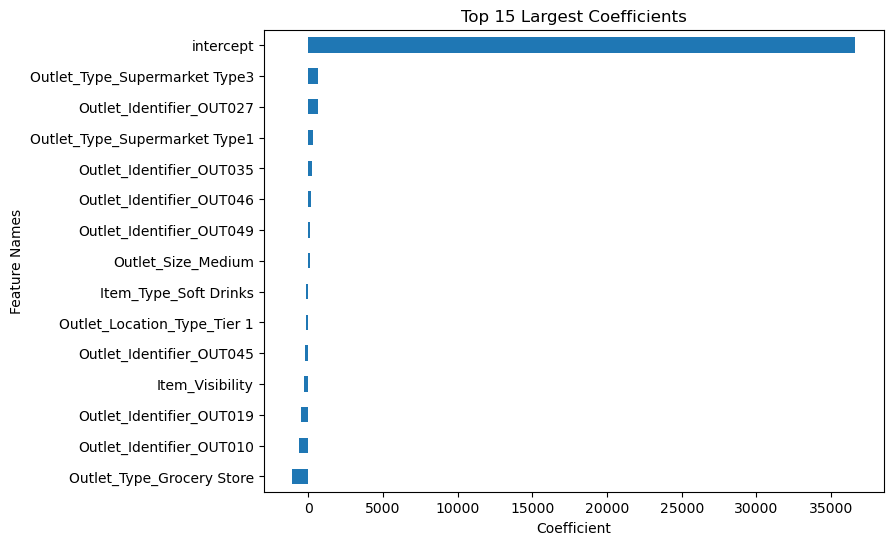

In [9]:
#Review model to verify it is intact
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_coeffs_linreg(loaded_model)
plot_coeffs_color(loaded_importances,top_n=15);

# Load in Tree Model

In [10]:
#Import joblib and the linear regression model
import joblib
loaded = joblib.load('reg_proj1a.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForestRegression'])

In [11]:
#Reload and unpack the models and datasets
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForestRegression']

In [12]:
#This function is for the evaluation of regression models (excludes linear regression)
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [13]:
evaluate_regression(loaded_model, X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 423.04
Test Data:	R^2= 0.56	RMSE= 1166.98


In [14]:
#This function is used to extract the most important features as importances

def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [15]:
model = loaded_model
get_importances(model)

Item_Weight                           0.052132
Item_Visibility                       0.095624
Item_MRP                              0.441817
Outlet_Establishment_Year             0.026454
Item_Identifier_infrequent_sklearn    0.000000
Item_Fat_Content_LF                   0.003050
Item_Fat_Content_Low Fat              0.006040
Item_Fat_Content_Regular              0.005484
Item_Fat_Content_low fat              0.001485
Item_Fat_Content_reg                  0.001543
Item_Type_Baking Goods                0.004411
Item_Type_Breads                      0.002772
Item_Type_Breakfast                   0.002517
Item_Type_Canned                      0.004135
Item_Type_Dairy                       0.005389
Item_Type_Frozen Foods                0.005679
Item_Type_Fruits and Vegetables       0.008090
Item_Type_Hard Drinks                 0.002766
Item_Type_Health and Hygiene          0.004226
Item_Type_Household                   0.006171
Item_Type_Meat                        0.003538
Item_Type_Oth

In [16]:
#This function is for the alignment of the color distionary to highlight the top_n features 

def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [17]:
#This function takes advantage of the ax argument to allow for creating 
#multiple subplots side by side for feature and permutation analysis in one visual

def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

NameError: name 'importances' is not defined

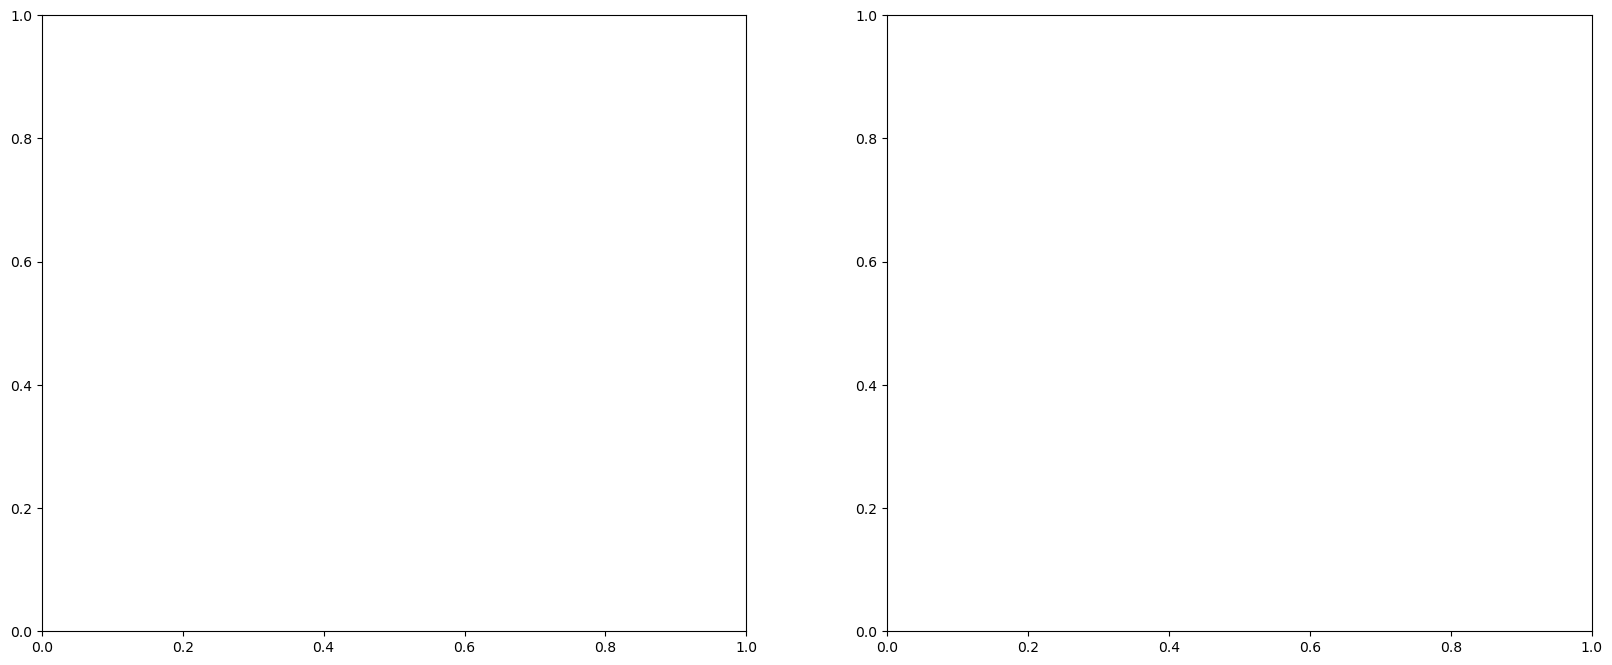

In [18]:
#Code to create the side by side subplots

fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 20 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()